In [29]:
import pandas as pd
import matplotlib
import math
import random
from matplotlib import pyplot as plt
import numpy
import geopandas as gpd
from shapely import Point
%matplotlib inline

# avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

pd.set_option('display.max_rows', 500)

In [30]:
# configure simulation
input_file = 'data/gis_incidences_nona.pkl'
number_of_simulations = 10000#10000000
a = 2
lk_identifier = 48
#starting_points = ((51, 42), (135, 142), (55, 250))
starting_points = ((351, 342), (435, 442), (355, 550))

# create grid
width = 1000 #215
height = 1000 #295
grid_side = 3

# width: 640km => 215 grid entries
# height: 876km => 295 grid entries
# => approx. 3km x 3km grid

grid = numpy.zeros((height, width), dtype=[('d1', 'int64'), ('d2', 'int64'), ('d3', 'int64'), ('x', 'int64'), ('y', 'int64'), ('z', 'int64')])

In [31]:
# simulate movements
for j in range(0, len(starting_points)):
    i = 0
    while i <= number_of_simulations:
        angle = random.uniform(0, 2 * math.pi)
        x = random.uniform(0, 1)
        d = (math.pow(x, (-1 / (a - 1)))) / 110 # convert distance to km, germany is approx. 876km high and 8 units in the current map
        pos_x = ((starting_points[j][0] * grid_side) + grid_side / 2) + (d * math.cos(angle))
        pos_y = ((starting_points[j][1] * grid_side) + grid_side / 2) + (d * math.sin(angle))

        if (0 <= pos_x < grid_side * width) and (0 <= pos_y < grid_side * height) \
                and (not ((math.floor(pos_x / grid_side) == starting_points[j][0]) and (math.floor(pos_y / grid_side) == starting_points[j][1]))):
            grid[math.floor(pos_y / grid_side)][math.floor(pos_x / grid_side)][j + 3] += 1
            i += 1

# simulate movements
#i = 0
#while i <= number_of_simulations:
#    angle = random.uniform(0, 2 * math.pi)
#    x = random.uniform(0, 1)
#    d = (math.pow(x, (-1 / (a - 1)))) / 110 # convert distance to km, germany is approx. 876km high and 8 units in the current map
#    pos_x = ((starting_point_x * grid_side) + grid_side / 2) + (d * math.cos(angle))
#    pos_y = ((starting_point_y * grid_side) + grid_side / 2) + (d * math.sin(angle))
#
#    while not ((0 <= pos_x <= grid_side * width) and (0 <= pos_y <= grid_side * height)):
#        angle = random.uniform(0, 2 * math.pi)
#        pos_x = ((starting_point_x * grid_side) + grid_side / 2) + (d * math.cos(angle))
#        pos_y = ((starting_point_y * grid_side) + grid_side / 2) + (d * math.sin(angle))
#
#    grid[math.floor(pos_x / grid_side)][math.floor(pos_y / grid_side)][0] += 1
#    i += 1

# print(grid)

In [32]:
# sum up the number of hits for a certain radius and set this sum as value to every square on this radius
# repeat this for every starting point

# Function to calculate the distance between two points
def calculate_distance(x1, y1, x2, y2):
    return math.dist((x1, y1), (x2, y2))

# calculate distances from starting points to compare later on
for i in range(0, width):
    for j in range(0, height):
        iter_x = (i * grid_side) + 1.5
        iter_y = (j * grid_side) + 1.5
        grid[j][i][0] = calculate_distance(iter_x, iter_y, starting_points[0][1] * grid_side, starting_points[0][0] * grid_side)
        grid[j][i][1] = calculate_distance(iter_x, iter_y, starting_points[1][1] * grid_side, starting_points[1][0] * grid_side)
        grid[j][i][2] = calculate_distance(iter_x, iter_y, starting_points[2][1] * grid_side, starting_points[2][0] * grid_side)



In [ ]:
# set sum of all values on radius to all squares on this radius
r = 1.5
squares_on_radius_sp1 = []
squares_on_radius_sp2 = []
squares_on_radius_sp3 = []
radius_sum_sp1 = 0.0
radius_sum_sp2 = 0.0
radius_sum_sp3 = 0.0
while r < 200:
    for i in range(0, width):
        for j in range(0, height):
            if r - 1.5 < grid[j][i][0] < r + 1.5:
                squares_on_radius_sp1.append(grid[j][i])
                radius_sum_sp1 += grid[j][i][3]
            if r - 1.5 < grid[j][i][1] < r + 1.5:
                squares_on_radius_sp2.append(grid[j][i])
                radius_sum_sp2 += grid[j][i][4]
            if r - 1.5 < grid[j][i][2] < r + 1.5:
                squares_on_radius_sp3.append(grid[j][i])
                radius_sum_sp3 += grid[j][i][5]

    for square in squares_on_radius_sp1:
        square[3] = radius_sum_sp1
    for square in squares_on_radius_sp2:
        square[4] = radius_sum_sp2
    for square in squares_on_radius_sp3:
        square[5] = radius_sum_sp3

    r += 3
    squares_on_radius_sp1 = []
    squares_on_radius_sp2 = []
    squares_on_radius_sp3 = []
    radius_sum_sp1 = 0.0
    radius_sum_sp2 = 0.0
    radius_sum_sp3 = 0.0

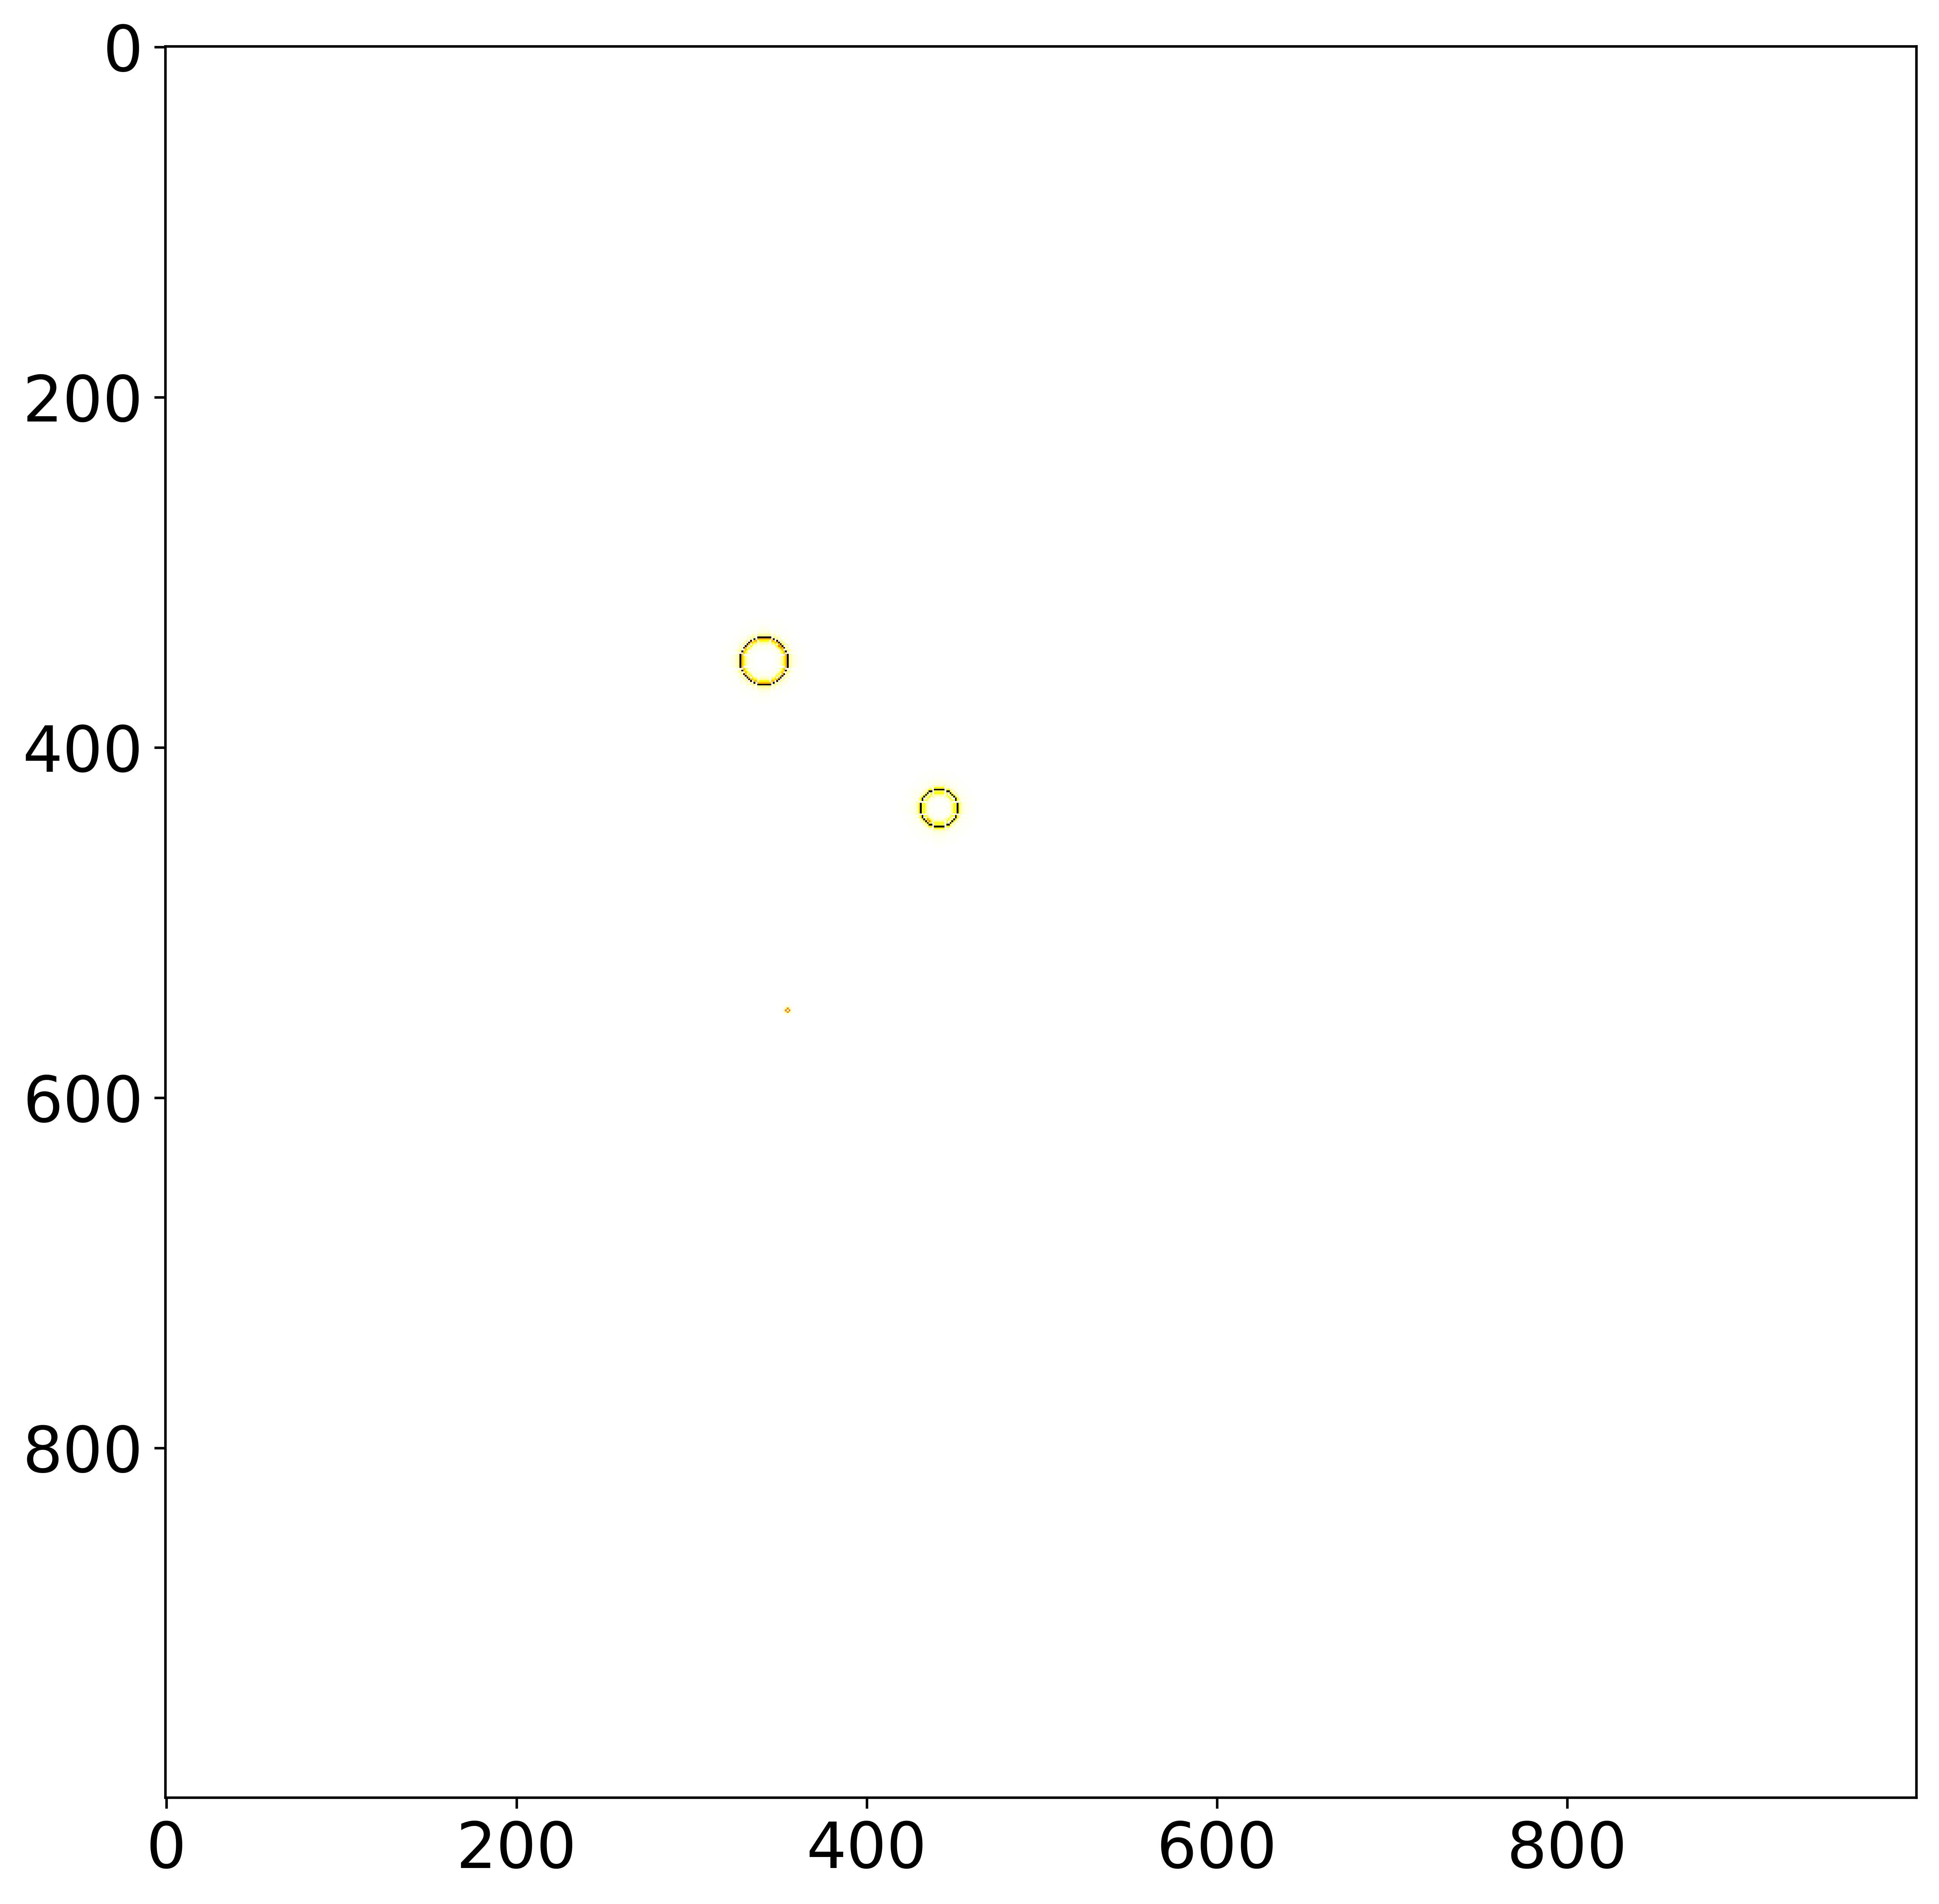

In [33]:
grid_cumulative = numpy.zeros((height, width))

i = 0
j = 0
for i in range (0, height):
    for j in range (0, width):
        grid_cumulative[i][j] += grid[i][j][3] + grid[i][j][4] + grid[i][j][5]

# print(grid_cumulative)

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.imshow(grid_cumulative, cmap='hot_r', interpolation="none")
plt.savefig("output.svg", format="svg", bbox_inches="tight")
#plt.show()